In [1]:
# Setup for Clipper R kernel

# Make sure both your personal lib and the system libs are visible
.libPaths(c(
  "/mnt/home/bisholea/Rlibs",
  "/opt/gvsu/clipper/2025.05/R/4.4.3/library",
  "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"
))

# Quick sanity check (optional, just to see)
.libPaths()
"ggplot2" %in% rownames(installed.packages())

# Load the packages you already have
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(fgsea)
library(cowplot)


[1] "/mnt/home/bisholea/Rlibs"                                                                                                       
[2] "/opt/gvsu/clipper/2025.05/R/4.4.3/library"                                                                                      
[3] "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"

[1] TRUE


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#!/usr/bin/env Rscript
suppressPackageStartupMessages({
  library(readr); library(dplyr); library(tidyr); library(tibble)
  library(purrr); library(ggplot2)
})

set.seed(1)

# ---------------- paths ----------------
capstone_dir <- "/mnt/projects/debruinz_project/bisholea/capstone"
gsea_dir     <- file.path(capstone_dir, "gsea")
fig_dir      <- file.path(capstone_dir, "figures")
dir.create(fig_dir, showWarnings = FALSE, recursive = TRUE)

# ---------------- load centralized data/style ----------------
fd <- readRDS(file.path(gsea_dir, "figdata.rds"))

# override theme locally for this script
fd$style$theme <- function() {
  ggplot2::theme_classic(base_size = 12, base_family = "serif") +
    ggplot2::theme(
      panel.grid          = ggplot2::element_blank(),
      plot.title.position = "plot",
      legend.title        = ggplot2::element_blank(),
      plot.margin         = ggplot2::margin(t = 3, r = 3, b = 3, l = 3),
      axis.title.x        = ggplot2::element_text(margin = ggplot2::margin(t = 4)),
      axis.title.y        = ggplot2::element_text(margin = ggplot2::margin(r = 4)),
      axis.ticks.length   = grid::unit(2, "pt")
    )
}

# palette + theme from figdata
pal_model <- if (!is.null(fd$palettes$model)) {
  fd$palettes$model
} else {
  c(AE = viridisLite::viridis(7)[4], NMF = "grey75")
}

plt_theme <- fd$style$theme()


save_pdf <- function(path, plot, w=7, h=5) {
  if (isTRUE(capabilities("cairo"))) {
    ggsave(path, plot, width=w, height=h, units="in", device=cairo_pdf, bg="white")
  } else {
    ggsave(path, plot, width=w, height=h, units="in", device="pdf", bg="white", useDingbats=FALSE)
  }
}

read_wide_matrix <- function(path, pathway_col = "pathway") {
  header <- readr::read_lines(path, n_max = 1)
  cols   <- strsplit(header, ",", fixed = TRUE)[[1]]
  pw_col <- if (pathway_col %in% cols) pathway_col else cols[1]
  other  <- setdiff(cols, pw_col)
  ct <- do.call(readr::cols, c(
    setNames(list(readr::col_character()), pw_col),
    setNames(rep(list(readr::col_double()), length(other)), other)
  ))
  df <- readr::read_csv(path, col_types = ct, show_col_types = FALSE)
  rn <- df[[pw_col]]; df[[pw_col]] <- NULL
  m <- as.matrix(df); rownames(m) <- rn; m
}

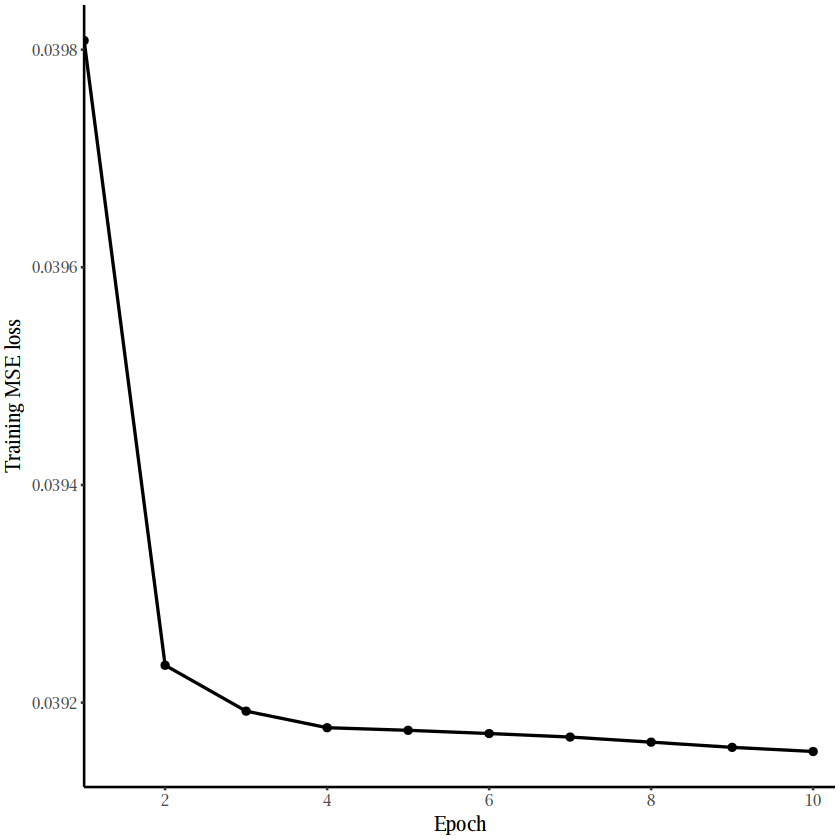

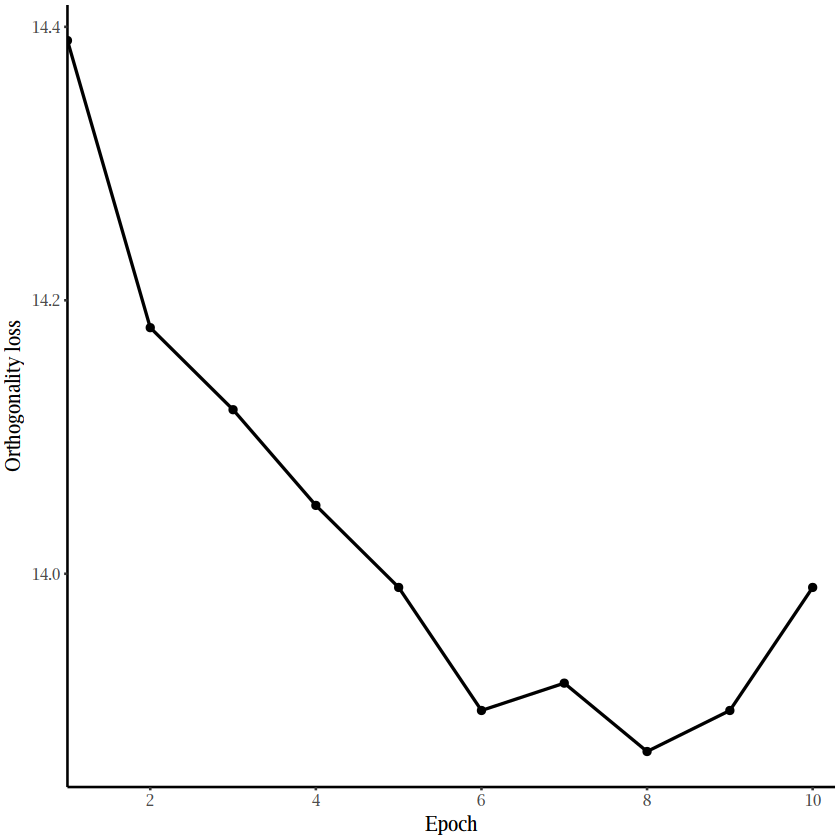

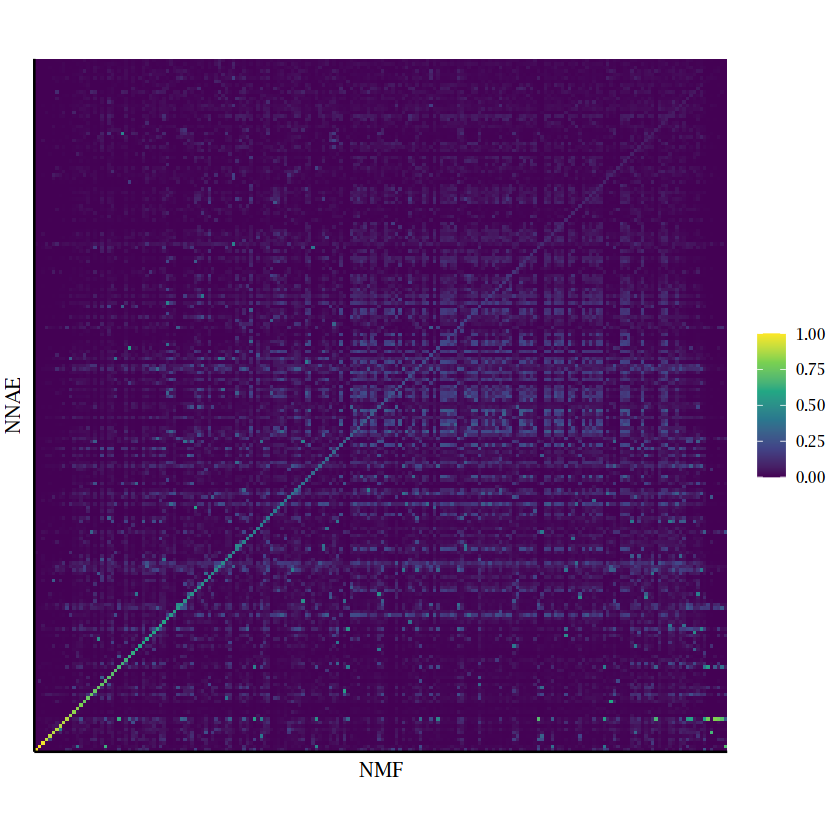

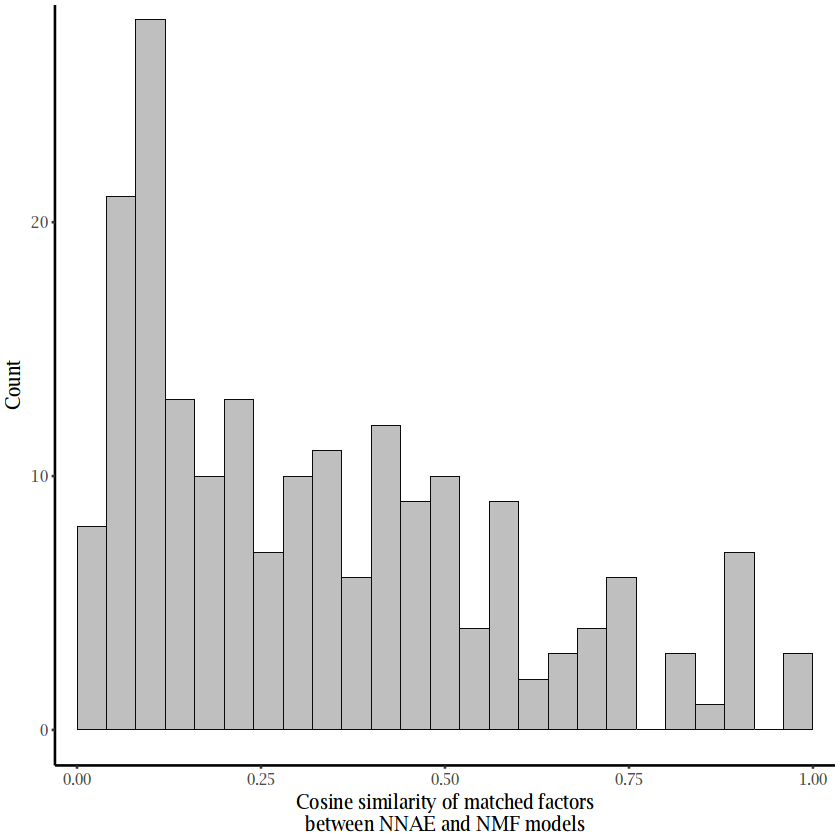

In [3]:
# ==========================================================
# A-B) Training loss and orthogonality loss per epoch
# ==========================================================

metrics_csv <- file.path(fig_dir, "60M_training_metrics_from_log.csv")   # epoch avg_loss + ortho
loss_csv    <- file.path(fig_dir, "60M_training_losses_from_pickle.csv") # epoch loss from pickle

# ---------------- read data ----------------
met <- readr::read_csv(metrics_csv, show_col_types = FALSE)

epoch_col <- dplyr::coalesce(
  names(met)[stringr::str_detect(names(met), "^epoch$")][1],
  names(met)[1]
)
loss_col_log <- dplyr::coalesce(
  names(met)[stringr::str_detect(names(met), "loss")][1],
  names(met)[2]
)
ortho_col <- dplyr::coalesce(
  names(met)[stringr::str_detect(names(met), "ortho|WWT|I")][1],
  names(met)[3]
)

met <- met %>%
  dplyr::transmute(
    epoch        = as.numeric(.data[[epoch_col]]),
    avg_loss_log = as.numeric(.data[[loss_col_log]]),
    ortho        = as.numeric(.data[[ortho_col]])
  )

# Loss from pickle-converted CSV: expect epoch, loss
loss_df <- readr::read_csv(loss_csv, show_col_types = FALSE)
loss_epoch_col <- dplyr::coalesce(
  names(loss_df)[stringr::str_detect(names(loss_df), "^epoch$")][1],
  names(loss_df)[1]
)
loss_val_col <- dplyr::coalesce(
  names(loss_df)[stringr::str_detect(names(loss_df), "loss")][1],
  names(loss_df)[2]
)
loss_df <- loss_df %>%
  dplyr::transmute(
    epoch        = as.numeric(.data[[loss_epoch_col]]),
    avg_loss_pkl = as.numeric(.data[[loss_val_col]])
  )

# Prefer the pickle loss if present; otherwise fall back to log loss
combo <- met %>%
  dplyr::full_join(loss_df, by = "epoch") %>%
  dplyr::arrange(epoch) %>%
  dplyr::mutate(
    avg_loss = dplyr::coalesce(avg_loss_pkl, avg_loss_log)
  ) %>%
  dplyr::filter(is.finite(epoch), is.finite(avg_loss), is.finite(ortho))

stopifnot(nrow(combo) > 0)

# compute nice y-limits for loss and orthogonality (zoomed in like the dual-axis plot)
loss_rng  <- range(combo$avg_loss, na.rm = TRUE)
ortho_rng <- range(combo$ortho,    na.rm = TRUE)

loss_pad  <- 0.05 * diff(loss_rng)   # 5% padding above/below
ortho_pad <- 0.05 * diff(ortho_rng)

if (!is.finite(loss_pad)  || loss_pad  == 0) loss_pad  <- 0.001 * max(abs(loss_rng))
if (!is.finite(ortho_pad) || ortho_pad == 0) ortho_pad <- 0.001 * max(abs(ortho_rng))

loss_limits  <- c(loss_rng[1]  - loss_pad,  loss_rng[2]  + loss_pad)
ortho_limits <- c(ortho_rng[1] - ortho_pad, ortho_rng[2] + ortho_pad)


# ---------------- Plot 1: Training (MSE) loss per epoch ----------------
max_epoch <- max(combo$epoch, na.rm = TRUE)
# make the largest even tick ≤ max_epoch
max_even  <- 2 * floor(max_epoch / 2)

p_loss <- ggplot(combo, aes(x = epoch, y = avg_loss)) +
  geom_line(linewidth = 0.7) +
  geom_point(shape = 16, size = 2) +
  scale_x_continuous(
    limits = c(1, max_epoch),
    breaks = seq(2, max_epoch, by = 2),   # 2, 4, 6, 8, 10
    expand = expansion(mult = c(0, 0.03))
  ) +
  scale_y_continuous(
    limits = loss_limits,
    expand = expansion(mult = c(0, 0))
  ) +
  labs(
    x = "Epoch",
    y = "Training MSE loss"
  ) +
  plt_theme


print(p_loss)
save_pdf(file.path(fig_dir, "train_loss_per_epoch.pdf"), p_loss)
ggplot2::ggsave(
  filename = file.path(fig_dir, "train_loss_per_epoch.png"),
  plot     = p_loss,
  width    = 4.5, height = 3.5, units = "in",
  dpi      = 300, bg = "white"
)

# ---------------- Plot 2: Orthogonality loss per epoch ----------------
p_ortho <- ggplot(combo, aes(x = epoch, y = ortho)) +
  geom_line(linewidth = 0.7) +
  geom_point(shape = 16, size = 2) +
  scale_x_continuous(
    limits = c(1, max_epoch),
    breaks = seq(2, max_epoch, by = 2),   # 2, 4, 6, 8, 10
    expand = expansion(mult = c(0, 0.03))
  ) +
  scale_y_continuous(
    limits = ortho_limits,
    expand = expansion(mult = c(0, 0))
  ) +
  labs(
    x = "Epoch",
    y = "Orthogonality loss"
  ) +
  plt_theme


print(p_ortho)
save_pdf(file.path(fig_dir, "orthogonality_per_epoch.pdf"), p_ortho)
ggplot2::ggsave(
  filename = file.path(fig_dir, "orthogonality_per_epoch.png"),
  plot     = p_ortho,
  width    = 4.5, height = 3.5, units = "in",
  dpi      = 300, bg = "white"
)

# ==========================================================
# C) Cosine heatmap in Hungarian-diagonal order
# ==========================================================
pairs_df <- fd$matching$best_pairs

if (!is.null(fd$matching$cosine_mat)) {
  S <- as.matrix(fd$matching$cosine_mat)
  ord <- order(pairs_df$cosine, decreasing = TRUE)
  S_diag <- S[pairs_df$ae_index[ord], pairs_df$nmf_index[ord], drop = FALSE]

  S_long <- tibble(
    AE_pos  = rep(seq_len(nrow(S_diag)) - 1, times = ncol(S_diag)),
    NMF_pos = rep(seq_len(ncol(S_diag)) - 1, each  = nrow(S_diag)),
    cosine  = as.vector(S_diag)
  )

  p_heat <- ggplot(S_long, aes(NMF_pos, AE_pos, fill = cosine)) +
    geom_raster() +
    scale_fill_viridis_c(
      limits = c(0, 1),
      name   = "Cosine Similarity"   # legend title
    ) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    labs(
      x = "NMF",
      y = "NNAE"
    ) +
    coord_equal() +                  # 1:1 aspect ratio
    plt_theme +
    theme(
      plot.title = element_text(hjust = 0),
      axis.text  = element_blank(),  # no tick labels
      axis.ticks = element_blank()   # no tick marks
    )

  save_pdf(file.path(fig_dir, "cosine_hungarian_diagonal.pdf"), p_heat,
           w = 4.5, h = 4.5)
  print(p_heat)
}

# ==========================================================
# D) Cosine similarities of matched AE–NMF pairs (histogram)
# ==========================================================
pairs_df <- fd$matching$best_pairs

p_cos_hist <- ggplot(pairs_df, aes(cosine)) +
  geom_histogram(
    breaks    = seq(0, 1, length.out = 25 + 1),  # 25 bins, first at 0
    color     = "black",   # thin black outline around bars
    linewidth = 0.2,
    fill      = "grey75"
  ) +
  scale_x_continuous(
    limits = c(0, 1),
    expand = c(0, 0.03)
  ) +
  scale_y_continuous(
    limits = c(0, NA),
    # space between x-axis and first bar (y = 0)
    expand = expansion(mult = c(0.05, 0.02))
  ) +
  labs(
    x = "Cosine similarity of matched factors\nbetween NNAE and NMF models",
    y = "Count"
  ) +
  plt_theme

save_pdf(file.path(fig_dir, "cosine_matched_hist.pdf"), p_cos_hist,
         w = 4.5, h = 3.5)
print(p_cos_hist)

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


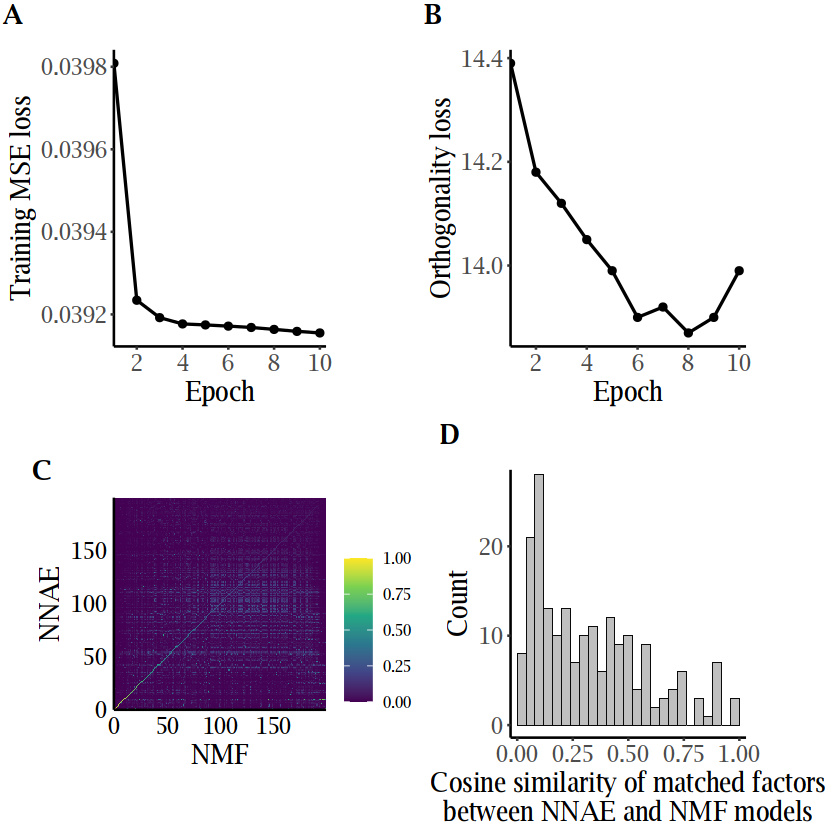

In [4]:
library(cowplot)
library(ggplot2)

# =========================
# 1) Extract legends
# =========================


# Heatmap colorbar legend
leg_heat <- get_legend(
  p_heat +
    theme(
      legend.position = "right",
      text = element_text(family = "serif")
    )
)

# =========================
# 2) Legend-free versions + tags
# =========================

fig2_tag_theme <- theme(
  legend.position = "none",
  axis.title.x = element_text(family = "serif", size = 16),
  axis.title.y = element_text(family = "serif", size = 16),
  axis.text.x  = element_text(family = "serif", size = 14),
  axis.text.y  = element_text(family = "serif", size = 14),
  plot.tag          = element_text(
    family = "serif",
    face   = "bold",
    size   = 16,   
  ),
  plot.tag.position = c(0.01, 1.1),
  plot.title        = element_text(hjust = 0),
  plot.margin       = margin(t = 30, r = 6, b = 8, l = 6)
)

p_loss_tag     <- p_loss      + fig2_tag_theme       + labs(tag = "A")
p_ortho_tag    <- p_ortho     + fig2_tag_theme       + labs(tag = "B")
p_heat_tag     <- p_heat      + fig2_tag_theme       + labs(tag = "C")  
p_cos_tag      <- p_cos_hist  + fig2_tag_theme       + labs(tag = "D")


# simple blank spacer (instead of plot_spacer())
sp <- ggplot() + theme_void()

# =========================
# 2.5) Align columns so all y-axes line up (A/C and B/D)
# =========================

# Left column: A (loss), C (heatmap)
aligned_left <- align_plots(
  p_loss_tag,
  p_heat_tag,
  align = "v",
  axis  = "l"
)
p_loss_tag_al     <- aligned_left[[1]]
p_heat_tag_al     <- aligned_left[[2]]

# Right column: B (ortho), D (cosine hist)
aligned_right <- align_plots(
  p_ortho_tag,
  p_cos_tag,
  align = "v",
  axis  = "l"
)
p_ortho_tag_al <- aligned_right[[1]]
p_cos_tag_al   <- aligned_right[[2]]

# =========================
# extra step: align C and D on the x-axis (bottom)
# =========================

bottom_pair <- align_plots(
  p_heat_tag_al,
  p_cos_tag_al,
  align = "h",
  axis  = "b"   # align on bottom axis
)

p_heat_tag_al2 <- bottom_pair[[1]]
p_cos_tag_al2  <- bottom_pair[[2]]

# =========================
# 3) Rows: [plot][legend][plot][legend]
# =========================

row1 <- plot_grid(
  p_loss_tag_al,  sp,
  p_ortho_tag_al, sp,
  nrow       = 1,
  rel_widths = c(4, 1, 4, 1)
)

sp <- ggplot() + theme_void()

row2 <- plot_grid(
  p_heat_tag_al2, leg_heat,
  p_cos_tag_al2,  sp,
  nrow       = 1,
  rel_widths = c(4, 1, 4, 1)
)

fig2 <- plot_grid(
  row1,
  row2,
  ncol        = 1,
  rel_heights = c(1, 1, 1)
)

print(fig2)

# =========================
# 4) Save
# =========================

panel_w <- 4.5
panel_h <- 3.5

# total width so that each plot panel is ~4.5 in
save_pdf(
  file.path(fig_dir, "figure2_panel.pdf"),
  fig2,
  w = 9,          # adjust if you want slightly narrower
  h = 2 * panel_h
)

ggsave(
  file.path(fig_dir, "figure2_panel.png"),
  fig2,
  width  = 9,
  height = 2 * panel_h,
  units  = "in",
  dpi    = 300,
  bg     = "white"
)